In [1]:
!make -C .. regression_df

make: Entering directory '/home/martibosch/data-science/invest-heat-islands'
make: Nothing to be done for 'regression_df'.
make: Leaving directory '/home/martibosch/data-science/invest-heat-islands'


In [2]:
import pandas as pd
import statsmodels.api as sm
import xarray as xr
from sklearn import (ensemble, inspection, linear_model, metrics,
                     model_selection, svm)
from sklearn import utils as sk_utils

from invest_heat_islands import utils

In [3]:
regression_df_filepath = '../data/interim/regression/regression-df.csv'

In [4]:
regression_df = pd.read_csv(regression_df_filepath, index_col=[0, 1])

In [5]:
def make_dataset(regression_df,
                 features=None,
                 target='tair_station',
                 shuffle=True):
    y = regression_df[target]
    if features is None:
        X = regression_df.drop(target, axis=1)
    else:
        X = regression_df[list(features)]

    if shuffle:
        X, y = sk_utils.shuffle(X, y)

    return X, y

In [6]:
regression_df.head()

lst_0    ndwi_0    lst_200  ndwi_200  \
2018-05-25 BOURG-EN-LAVAUX  26.014134 -0.334515  26.754689 -0.266422   
           BOVDCH           21.650461 -0.456614  21.830704 -0.392005   
           BOVDMR           26.395785 -0.229706  26.079124 -0.269882   
           BOVDSO           21.088022 -0.465147  21.477795 -0.417006   
           MARCELIN         24.975926 -0.355455  25.100744 -0.343064   

                              lst_400  ndwi_400    lst_600  ndwi_600  \
2018-05-25 BOURG-EN-LAVAUX  26.528556 -0.275616  26.043737 -0.260330   
           BOVDCH           22.426036 -0.401703  22.464239 -0.406227   
           BOVDMR           25.949049 -0.262776  25.356981 -0.217986   
           BOVDSO           22.195320 -0.388652  22.970605 -0.376730   
           MARCELIN         24.344891 -0.371353  24.286819 -0.371502   

                              lst_800  ndwi_800  elev  tair_station  
2018-05-25 BOURG-EN-LAVAUX  25.255805 -0.219232   519          21.0  
           BOVDCH           22.308259 -0.396235   680          17.8  
           BOVDMR           24.551374 -0.167194   380          22.3  
           BOVDSO           23.260748 -0.365749   500          20.3  
           MARCELIN         24.394364 -0.367017   436          18.8

After dropping the missing observations, the total number of samples is:

In [7]:
len(regression_df)

88

## Model performance

In [8]:
target = 'tair_station'

model_dict = {
    'lr': linear_model.LinearRegression,
    'svm': svm.SVR,    
    'rf': ensemble.RandomForestRegressor
}

In [9]:
X, y = make_dataset(regression_df, target=target)

model_perf_df = pd.DataFrame(columns=utils.METRIC_COLUMNS)
for model_label in model_dict:
    model = model_dict[model_label]
    regr = model().fit(X, y)
    y_pred = regr.predict(X)
    model_perf_df.loc[model.__name__] = utils.compute_model_perf(y, y_pred)

model_perf_df.style.set_caption('Table 1. Model performance with all samples')

,R^2,MAE,RMSE
LinearRegression,0.806953,1.354900,1.658555
SVR,0.034038,2.862458,3.710037
RandomForestRegressor,0.947299,0.677655,0.866575


If all the samples are considered, the random forest regressor achieves the best fit with a coefficient of determination of $R^2 = 0.947$, followed by the $R^2 = 0.807$ achieved by the ordinary linear regression.

### Cross validation

In [10]:
num_repetitions = 20
num_folds = 3

In [11]:
accuracy_df = pd.DataFrame(columns=model_dict.keys(),
                           index=range(num_repetitions))

for i in range(num_repetitions):
    X, y = make_dataset(regression_df, target=target)

    for model_label in model_dict:
        accuracy_df.loc[(i, model_label)] = model_selection.cross_val_score(
            model_dict[model_label](), X, y, cv=num_folds).mean()

# output a Table with nicer row/column labels
pd.DataFrame({
    'Cross validation R^2': accuracy_df.mean()
}).rename(index=lambda model_label: model_dict[model_label].__name__
          ).style.set_caption('Table 2. Cross validation scores')

,Cross validation R^2
LinearRegression,0.698887
SVR,-0.043546
RandomForestRegressor,0.603736


The cross validation suggests that the linear regression is more robust to missing data and also less likely to over-fit the observations than the random forest regressor.

## Feature importance

In [12]:
X, y = make_dataset(regression_df, target=target)

for model_label in model_dict:
    model = model_dict[model_label]
    regr = model().fit(X, y)

    importance_df = pd.DataFrame(
        inspection.permutation_importance(regr, X, y),
        index=regression_df.drop(target, axis=1).columns,
        columns=[f'importances_{param}' for param in ('mean', 'std')])
    print(model)
    print(
        importance_df.sort_values(by='importances_mean',
                                  ascending=False).head(10))
    print()

<class 'sklearn.linear_model._base.LinearRegression'>
          importances_mean  importances_std
ndwi_600         22.794003         0.500453
lst_800          11.429434         0.930492
ndwi_400         10.602427         0.536945
ndwi_800          8.780511         0.488296
lst_400           8.285906         0.542134
ndwi_200          0.309577         0.031235
lst_600           0.215181         0.024390
ndwi_0            0.100158         0.013527
lst_0             0.029726         0.008733
lst_200           0.010284         0.003550

<class 'sklearn.svm._classes.SVR'>
          importances_mean  importances_std
elev          1.076242e-01     2.044758e-02
lst_0         2.123911e-03     1.964829e-04
lst_200       1.998739e-03     1.843823e-04
lst_400       1.762446e-03     1.970904e-04
lst_800       1.737247e-03     1.619875e-04
lst_600       1.697454e-03     1.795674e-04
ndwi_0        5.011616e-07     1.138357e-07
ndwi_200      2.220464e-07     6.411543e-08
ndwi_400      1.912759e-07    

The feature importances change dramatically according to the regression model.

In the case of linear regression, the feature importances can be futher assessed by a F-test of significance:

In [13]:
est = sm.OLS(y, sm.add_constant(X))
est.fit().summary(title='Table 3. OLS regression results')

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Table 3. OLS regression results                        
==============================================================================
Dep. Variable:           tair_station   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     28.88
Date:                Tue, 05 May 2020   Prob (F-statistic):           9.42e-23
Time:                        18:31:25   Log-Likelihood:                -169.39
No. Observations:                  88   AIC:                             362.8
Df Residuals:                      76   BIC:                             392.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9995      3.705      1.080      0.284      -3.380      11.379
lst_0          0.1165      0.642      0.181      0.857      -1.163       1.396
ndwi_0        -6.2973      5.638     -1.117      0.268     -17.527       4.932
lst_200        0.0680      0.973      0.070      0.944      -1.870       2.006
ndwi_200     -15.9853     17.135     -0.933      0.354     -50.113      18.143
lst_400       -2.2093      1.942     -1.138      0.259      -6.076       1.658
ndwi_400      91.4700     51.413      1.779      0.079     -10.927     193.867
lst_600        0.3572      3.259      0.110      0.913      -6.134       6.848
ndwi_600    -127.0487     61.512     -2.065      0.042    -249.560      -4.537
lst_800        2.6685      1.853      1.440      0.154      -1.023       6.360
ndwi_800      80.5019     25.000      3.220      0.002      30.711     130.293
elev          -0.0022      0.004     -0.623      0.535      -0.009       0.005
==============================================================================
Omnibus:                        7.476   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                7.748
Skew:                           0.725   Prob(JB):                       0.0208
Kurtosis:                       2.900   Cond. No.                     2.27e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

With a significance level of $p=0.05$, the results of the F-test suggest that the significant variables for the linear regression are the NDWI when spatially averaged over a 400m, 600m and 800m radius. The following most significant variable is the LST, spatially averaged over a 800m radius ($p=0.154$).

## Prediction with the chosen model

In [14]:
X, y = make_dataset(regression_df, shuffle=False)

# regr = ensemble.RandomForestRegressor().fit(X, y)
regr = linear_model.LinearRegression().fit(X, y)

y_pred = regr.predict(X)

## Unraveling the error patterns

In [15]:
comparison_df = regression_df.copy()

comparison_df['obs'] = y
comparison_df['pred'] = y_pred
comparison_df['err'] = y_pred - y
# comparison_df['sq_err'] = comparison_df['err']**2

comparison_df['date'] = pd.to_datetime(comparison_df.index.get_level_values(0))
comparison_df['station'] = comparison_df.index.get_level_values(1)

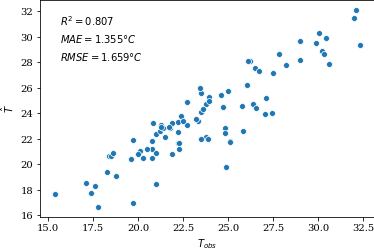

In [16]:
fig = utils.plot_pred_obs(comparison_df)
fig.savefig('../reports/figures/spatial-regression-pred-obs.pdf')

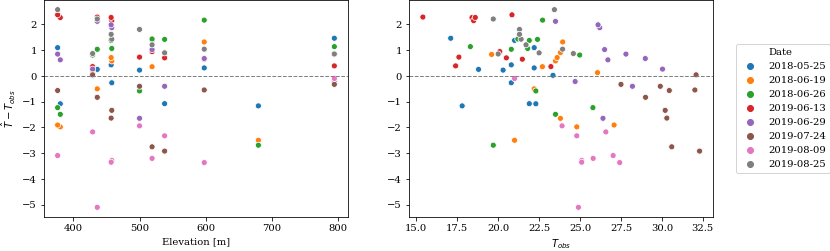

In [17]:
fig = utils.plot_err_elev_obs(comparison_df)
fig.savefig('../reports/figures/spatial-regression-errors.pdf')

### Plotting the maps predicted by the spatial regression

In [18]:
!make -C .. tair_regr_maps

make: Entering directory '/home/martibosch/data-science/invest-heat-islands'
make: Nothing to be done for 'tair_regr_maps'.
make: Leaving directory '/home/martibosch/data-science/invest-heat-islands'


In [19]:
tair_regr_filepath = '../data/processed/tair-regr-maps.nc'
station_locations_filepath = '../data/raw/stations/station-locations.csv'

In [20]:
T_regr_da = xr.open_dataarray(tair_regr_filepath)
station_location_df = pd.read_csv(station_locations_filepath, index_col='stn')

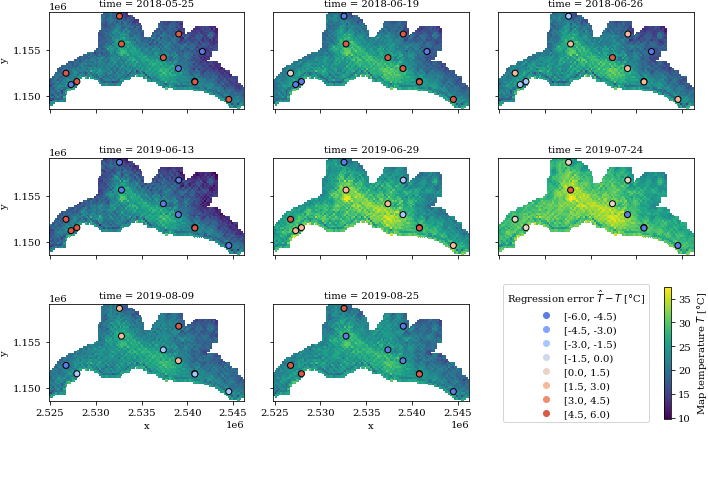

In [21]:
g = utils.plot_T_maps(T_regr_da,
                      station_location_df,
                      comparison_df=comparison_df)
g.fig.savefig('../reports/figures/spatial-regression-maps.png')